In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle,warnings
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/inf648-pucp-2024-01-aprendizaje-automatico/sample_submission.csv
/kaggle/input/inf648-pucp-2024-01-aprendizaje-automatico/test_x.csv
/kaggle/input/inf648-pucp-2024-01-aprendizaje-automatico/train.csv


In [2]:
file_name = "/kaggle/input/inf648-pucp-2024-01-aprendizaje-automatico/train.csv"

dt = pd.read_csv(file_name)
print(dt.shape)
dt.head()


(32538, 22)


,Id,Edad,Trabajo,Estado Civil,Educacion,Credito por Defecto,Prestamo Vivienda,Prestamo Personal,Contacto,Mes,...,Cantidad Contactos Realizados,Cantidad Dias desde Ultimo Contacto,Cantidad Contactos Previos Realizados,Resultado Campaña Anterior,Tasa Variacion Empleo,Indice Precios Consumidor,Indice Confianza Consumidor,Tasa Interes 3 meses,Cantidad Empleados,Subscripcion Deposito
0,0,44,tecnico,divorciado,curso_profesional,no,no,si,telefono,junio,...,2,999,0,inexistente,1.4,94.465,-41.8,4.961,5228.1,no
1,1,30,administrador,soltero,grado_universitario,no,no,si,celular,julio,...,2,999,0,inexistente,1.4,93.918,-42.7,4.961,5228.1,no
2,2,41,administración,casado,secundaria_completa,valor_que_falta,no,no,celular,mayo,...,1,999,0,inexistente,-1.8,92.893,-46.2,1.291,5099.1,no
3,3,31,trabajador_industria,soltero,primaria_4_grado,valor_que_falta,si,no,celular,mayo,...,1,999,0,inexistente,-1.8,92.893,-46.2,1.250,5099.1,no
4,4,35,empleado_ por_cuenta_propia,casado,grado_universitario,no,si,no,celular,julio,...,1,999,0,inexistente,1.4,93.918,-42.7,4.958,5228.1,no


In [3]:
dt["Subscripcion Deposito"].value_counts()*100/len(dt)
#la data está en proporcion 88% No, clase dominante y 11% si, entonces luego deberemos balancear la data
#estrategias: 1)reducir filas de la clase dominante o 2) aumentar filas de la clase no dominante


Subscripcion Deposito
no    88.733174
si    11.266826
Name: count, dtype: float64

In [4]:
def prestamo(d1,d2):
    if ((d1==2) | (d2==2)):
      return "2"
    elif ((d1==0 & d2==1) | (d1==1 & d2==0) | (d1==1 & d2==1)):
      return "1"
    else:
      return "0"

In [6]:
warnings.filterwarnings('ignore')
def preprocess_dataset(dataset):
  preprocessed_dataset = dataset.copy()

    #ID no aporta información al modelado
  if "Id" in preprocessed_dataset:
    preprocessed_dataset.drop(["Id"], axis=1, inplace=True)
    #Duración debe ser eliminada por indicación expresa del caso, esta columna está muy relacionada con la variable objetivo
  if "Duracion" in preprocessed_dataset:
    preprocessed_dataset.drop(["Duracion"], axis=1, inplace=True)
    
#En el análisis de importancia de características, 'Contacto', 'Credito por Defecto', Cantidad Contactos Previos Realizados son las que menos aportan al modelo
  if "Contacto" in preprocessed_dataset:
    preprocessed_dataset.drop(["Contacto"], axis=1, inplace=True)
  if "Credito por Default " in preprocessed_dataset:
    preprocessed_dataset.drop(["Credito por Defecto"], axis=1, inplace=True)
  if "Cantidad Contactos Previos Realizados" in preprocessed_dataset:
    preprocessed_dataset.drop(["Cantidad Contactos Previos Realizados"], axis=1, inplace=True)
    
  preprocessed_dataset["Prestamo Vivienda"].replace({"no": "0", "si": "1", "valor_que_falta":"2"}, inplace=True)
  preprocessed_dataset["Prestamo Personal"].replace({"no": "0", "si": "1", "valor_que_falta":"2"}, inplace=True)
  preprocessed_dataset.insert(6,"Prestamo",preprocessed_dataset.apply(lambda x: prestamo(int(x["Prestamo Vivienda"]),int(x["Prestamo Personal"])), axis=1)) 

  preprocessed_dataset.drop(["Prestamo Vivienda","Prestamo Personal"], axis=1, inplace=True)
   

  preprocessed_dataset["Trabajo"].replace(to_replace =["emprendedor","empleado_ por_cuenta_propia"], value="independiente", inplace =True)
  preprocessed_dataset["Trabajo"].replace(to_replace =["administración","administrador","empleada_domestica","trabajador_industria","tecnico","servicios"], value="dependiente", inplace =True)
  preprocessed_dataset["Trabajo"].replace(to_replace =["desempleado","estudiante","retirado"], value="sin-sueldo", inplace =True)
    #Agrupamos los tipos de trabajo por tipo: dependiente, independiente, sin-sueldo y desconocido

  #Agrupamos los niveles de primaria en uno solo
  preprocessed_dataset["Educacion"].replace(to_replace =["primaria_4_grado","primaria_3_grado","primaria_6_grado"], value="primaria",inplace =True)

    #Transformamos los meses agrupados por trimestres
  preprocessed_dataset["Mes"].replace(to_replace =["enero","febrero","marzo"], value="1T",inplace =True)
  preprocessed_dataset["Mes"].replace(to_replace =["abril","mayo","junio"], value="2T",inplace =True)
  preprocessed_dataset["Mes"].replace(to_replace =["julio","agosto","septiembre"], value="3T",inplace =True)
  preprocessed_dataset["Mes"].replace(to_replace =["octubre","noviembre","diciembre"], value="4T",inplace =True)
  

 #"Cantidad de dias último contacto" --> standard scaler por el 999
  s=StandardScaler()
  preprocessed_dataset[["Cantidad Dias desde Ultimo Contacto"]]=s.fit_transform(preprocessed_dataset[["Cantidad Dias desde Ultimo Contacto"]])
 
  label_encoder = LabelEncoder()

    #Transformamos las columnas categóricas a numéricas
  for column in preprocessed_dataset.columns:
    if not pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
      preprocessed_dataset[column] = label_encoder.fit_transform(preprocessed_dataset[column])

      print("La columna '{}', será codificada como: {}".format(column, dict(enumerate(label_encoder.classes_))))
  
  return preprocessed_dataset

In [7]:
#Transformamos la data de acuerdo a los criterios definidos en la función previa
preprocessed_dataset = preprocess_dataset(dt)
preprocessed_dataset.head(10)
preprocessed_dataset.info()


La columna 'Trabajo', será codificada como: {0: 'dependiente', 1: 'independiente', 2: 'sin-sueldo', 3: 'valor_que_falta'}
La columna 'Estado Civil', será codificada como: {0: 'casado', 1: 'divorciado', 2: 'soltero', 3: 'valor_que_falta'}
La columna 'Educacion', será codificada como: {0: 'analfabeto', 1: 'curso_profesional', 2: 'grado_universitario', 3: 'primaria', 4: 'secundaria_completa', 5: 'valor_que_falta'}
La columna 'Credito por Defecto', será codificada como: {0: 'no', 1: 'si', 2: 'valor_que_falta'}
La columna 'Prestamo', será codificada como: {0: '0', 1: '1', 2: '2'}
La columna 'Mes', será codificada como: {0: '1T', 1: '2T', 2: '3T', 3: '4T'}
La columna 'Dia Semana', será codificada como: {0: 'jueves', 1: 'lunes', 2: 'martes', 3: 'miercoles', 4: 'viernes'}
La columna 'Resultado Campaña Anterior', será codificada como: {0: 'exitoso', 1: 'fallido', 2: 'inexistente'}
La columna 'Subscripcion Deposito', será codificada como: {0: 'no', 1: 'si'}
<class 'pandas.core.frame.DataFrame'>


# Separamos la data y creamos los set de entrenamiento y validación

In [9]:
#import seaborn as sns
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(preprocessed_dataset.iloc[:,:-1], preprocessed_dataset.iloc[:, -1])
#df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
#df = df.sample(frac=0.5)
#sns.countplot(df.iloc[:,-1])

df["Subscripcion Deposito"].value_counts()*100/len(dt)

#x = df.drop(["Subscripcion Deposito"], axis=1)
#y = df["Subscripcion Deposito"]


Subscripcion Deposito
1    44.468007
0    44.265167
Name: count, dtype: float64

In [10]:
x = preprocessed_dataset.drop(["Subscripcion Deposito"], axis=1)
y = preprocessed_dataset["Subscripcion Deposito"]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [11]:
x_train

,Edad,Trabajo,Estado Civil,Educacion,Credito por Defecto,Prestamo,Mes,Dia Semana,Cantidad Contactos Realizados,Cantidad Dias desde Ultimo Contacto,Resultado Campaña Anterior,Tasa Variacion Empleo,Indice Precios Consumidor,Indice Confianza Consumidor,Tasa Interes 3 meses,Cantidad Empleados
26157,26,2,2,2,0,1,3,1,1,0.194153,2,-3.0,92.713,-33.0,0.709,5023.5
15707,43,0,0,3,2,2,1,2,1,0.194153,2,-1.8,92.893,-46.2,1.344,5099.1
31627,45,0,0,2,0,0,2,2,1,0.194153,2,1.4,93.444,-36.1,4.963,5228.1
22327,37,0,0,3,2,0,1,4,2,0.194153,2,1.1,93.994,-36.4,4.859,5191.0
17519,56,0,0,3,0,1,1,0,1,0.194153,2,-1.8,92.893,-46.2,1.327,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6009,30,0,0,3,0,0,2,4,2,0.194153,2,1.4,93.918,-42.7,4.963,5228.1
27268,46,0,0,1,0,0,1,0,1,0.194153,2,1.1,93.994,-36.4,4.860,5191.0
7139,39,0,0,2,0,1,2,4,4,0.194153,2,1.4,93.444,-36.1,4.964,5228.1
21876,49,0,0,1,0,0,2,0,3,0.194153,2,1.4,93.918,-42.7,4.962,5228.1


In [13]:
modelos = [
    #('LogisticRegression', LogisticRegression(solver='liblinear', random_state=0)),
    ('LogisticRegression', LogisticRegression(solver='liblinear', random_state=0)),
    ('RandomForest', RandomForestClassifier(max_depth= 12, max_features= 'sqrt', min_samples_leaf= 20, n_estimators = 100)),
    ('XGBClassifier', XGBClassifier(max_depth=10, max_features= 'auto', min_samples_leaf= 1, n_estimators= 50)),
    ('GradientBoostingClass', GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0))
]

#procedimiento para comparar los modelos
for nombre, modelo in modelos:
    kfold = KFold(n_splits=10)
    cvs = cross_val_score(modelo, x_train, y_train, cv=kfold, scoring='accuracy')
    msg = "%s. accuracy score: %f, std: (%f)" % (nombre, cvs.mean(), cvs.std())
    print(msg)


LogisticRegression. accuracy score: 0.899270, std: (0.004590)
RandomForest. accuracy score: 0.900077, std: (0.004478)
XGBClassifier. accuracy score: 0.892163, std: (0.006786)
GradientBoostingClass. accuracy score: 0.899155, std: (0.003792)


# Gráficos de curvas ROC y roc_AUC

LogisticRegression Accuracy: 0.898740012292563


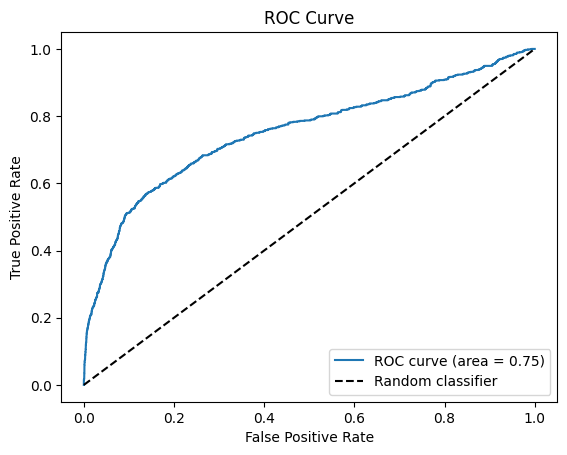

RandomForest Accuracy: 0.8999692685925015


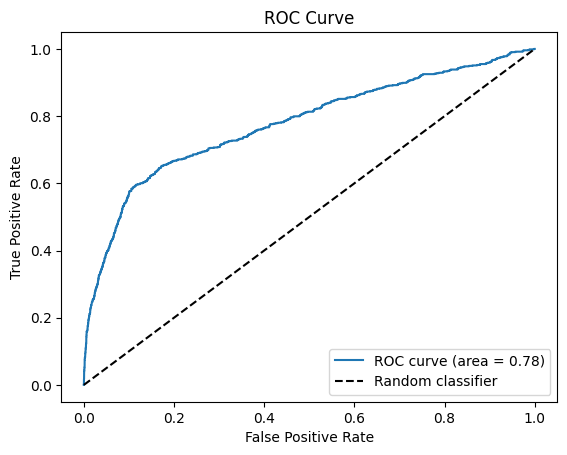

XGBClassifier Accuracy: 0.8904425322679779


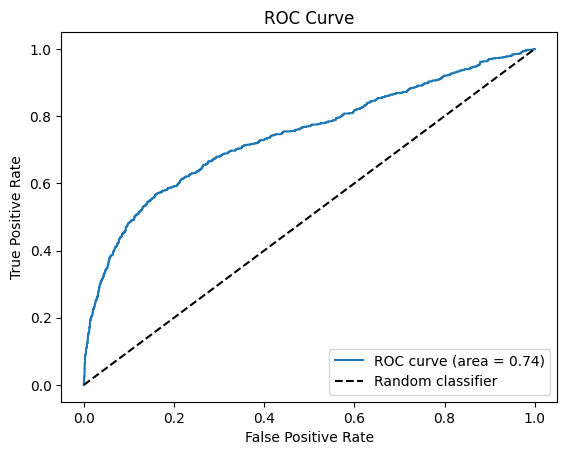

GradientBoostingClass Accuracy: 0.8972034419176398


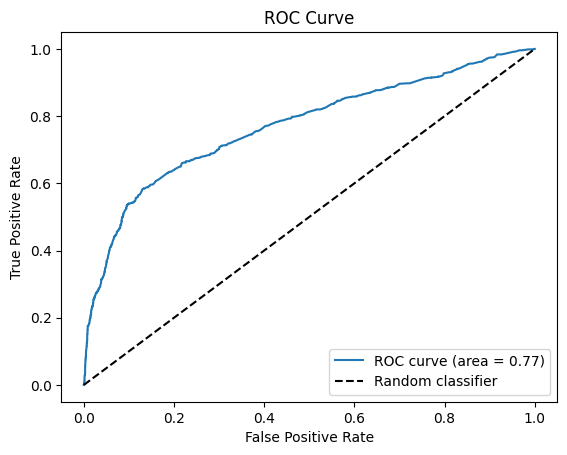

In [15]:
#Gráfico de las curvas ROC de los 4 modelos
for nombre, modelo in modelos:
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(nombre,"Accuracy:", accuracy)
    
    y_pred_prob = modelo.predict_proba(x_test)[:, 1] 
    # Compute the false positive rate (FPR)  
    # and true positive rate (TPR) for different classification thresholds 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    # Compute the ROC AUC score 
    roc_auc = roc_auc_score(y_test, y_pred_prob) 
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
    # roc curve for tpr = fpr  
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('ROC Curve') 
    plt.legend(loc="lower right") 
    plt.show()


# **Data x_train**

In [16]:
file_name = "/kaggle/input/inf648-pucp-2024-01-aprendizaje-automatico/test_x.csv"
dt_test=pd.read_csv(file_name)
dt_test.shape
dt_test.head()

,Id,Edad,Trabajo,Estado Civil,Educacion,Credito por Defecto,Prestamo Vivienda,Prestamo Personal,Contacto,Mes,...,Duracion,Cantidad Contactos Realizados,Cantidad Dias desde Ultimo Contacto,Cantidad Contactos Previos Realizados,Resultado Campaña Anterior,Tasa Variacion Empleo,Indice Precios Consumidor,Indice Confianza Consumidor,Tasa Interes 3 meses,Cantidad Empleados
0,0,30,trabajador_industria,casado,primaria_3_grado,no,si,no,celular,mayo,...,487,2,999,0,inexistente,-1.8,92.893,-46.2,1.313,5099.1
1,1,39,servicios,soltero,secundaria_completa,no,no,no,telefono,mayo,...,346,4,999,0,inexistente,1.1,93.994,-36.4,4.855,5191.0
2,2,25,servicios,casado,secundaria_completa,no,si,no,telefono,junio,...,227,1,999,0,inexistente,1.4,94.465,-41.8,4.962,5228.1
3,3,38,servicios,casado,primaria_3_grado,no,valor_que_falta,valor_que_falta,telefono,junio,...,17,3,999,0,inexistente,1.4,94.465,-41.8,4.959,5228.1
4,4,47,administrador,casado,grado_universitario,no,si,no,celular,noviembre,...,58,1,999,0,inexistente,-0.1,93.200,-42.0,4.191,5195.8


In [17]:
preprocessed_dataset = preprocess_dataset(dt_test)
x_test_new = preprocessed_dataset

La columna 'Trabajo', será codificada como: {0: 'dependiente', 1: 'independiente', 2: 'sin-sueldo', 3: 'valor_que_falta'}
La columna 'Estado Civil', será codificada como: {0: 'casado', 1: 'divorciado', 2: 'soltero', 3: 'valor_que_falta'}
La columna 'Educacion', será codificada como: {0: 'analfabeto', 1: 'curso_profesional', 2: 'grado_universitario', 3: 'primaria', 4: 'secundaria_completa', 5: 'valor_que_falta'}
La columna 'Credito por Defecto', será codificada como: {0: 'no', 1: 'si', 2: 'valor_que_falta'}
La columna 'Prestamo', será codificada como: {0: '0', 1: '1', 2: '2'}
La columna 'Mes', será codificada como: {0: '1T', 1: '2T', 2: '3T', 3: '4T'}
La columna 'Dia Semana', será codificada como: {0: 'jueves', 1: 'lunes', 2: 'martes', 3: 'miercoles', 4: 'viernes'}
La columna 'Resultado Campaña Anterior', será codificada como: {0: 'exitoso', 1: 'fallido', 2: 'inexistente'}


In [18]:
mdl = XGBClassifier(max_depth=10, max_features= 'auto', min_samples_leaf= 1, n_estimators= 50)
#mdl = RandomForestClassifier(max_depth= 12, max_features= 'sqrt', min_samples_leaf= 20, n_estimators = 100)
#mdl = LogisticRegression(solver='liblinear', random_state=0)

mdl.fit(x_train, y_train)
y_predict = mdl.predict(x_test_new)

y_pred_prob = mdl.predict_proba(x_test_new)[:, 1]
y_pred_prob

array([0.05092193, 0.00582971, 0.0272069 , ..., 0.11016049, 0.034625  ,
       0.06396615], dtype=float32)

In [19]:
#Generamos el archivo a enviar, con las predicciones (probabilidades)
archivo_subm = pd.DataFrame({'Id':dt_test.Id, 'Subscripcion Deposito':y_pred_prob})
archivo_subm.to_csv('submissionXGB6.csv', index=False)

